In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# EDA
- Dataset Overview

CLASS DISTRIBUTION
TRAIN → Glioma    : 1121 | Meningioma: 1139 | Notumor   : 1395 | Pituitary : 1257 | Total:  4912
VAL   → Glioma    :  201 | Meningioma:  201 | Notumor   :  201 | Pituitary :  201 | Total:   804
TEST  → Glioma    :  300 | Meningioma:  306 | Notumor   :  405 | Pituitary :  300 | Total:  1311

OVERALL → Glioma    :  1622 | Meningioma:  1646 | Notumor   :  2001 | Pituitary :  1758 | Total:   7027


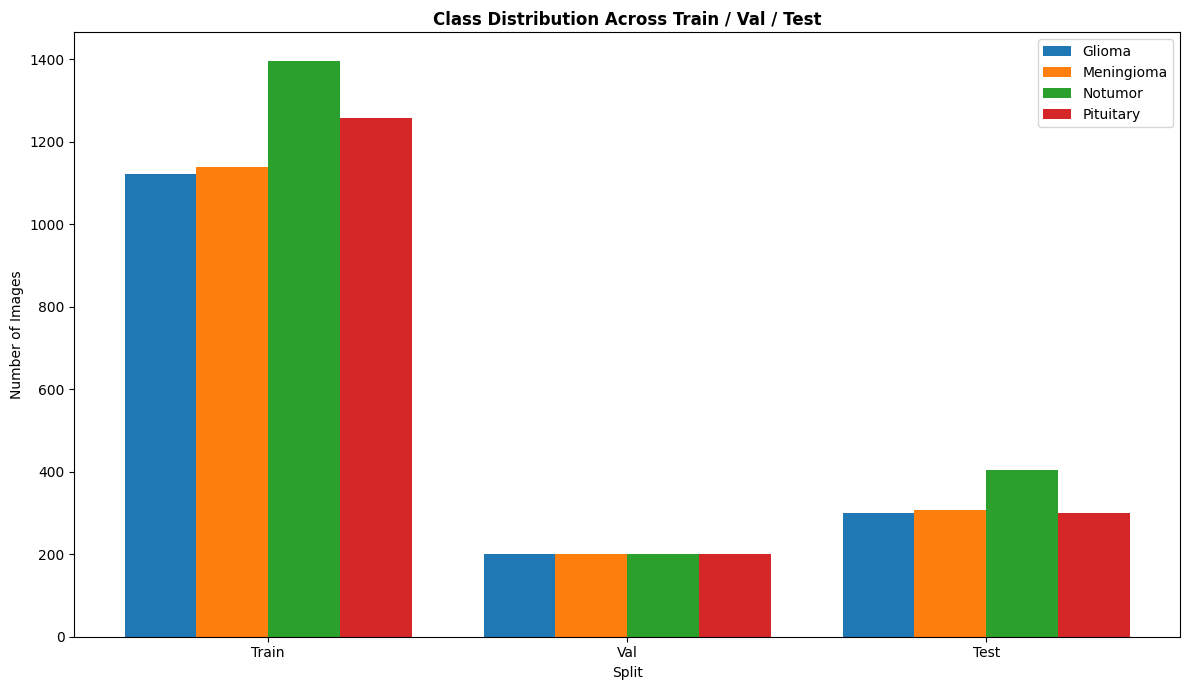

In [2]:
import os
import matplotlib.pyplot as plt

# YOUR EXACT PATHS
TRAIN_DIR = '/content/drive/MyDrive/archive/Train'
VAL_DIR   = '/content/drive/MyDrive/archive/Val'
TEST_DIR  = '/content/drive/MyDrive/archive/Test'

CLASSES = ['glioma', 'meningioma', 'notumor', 'pituitary']

def count_classes(folder_path, folder_name):
    if not os.path.exists(folder_path):
        print(f"{folder_name} folder not found!")
        return {cls: 0 for cls in CLASSES}, 0

    counts = {}
    total = 0

    for cls in CLASSES:
        class_path = os.path.join(folder_path, cls)
        if os.path.exists(class_path):
            counts[cls] = len(os.listdir(class_path))
        else:
            counts[cls] = 0
        total += counts[cls]

    return counts, total


# Run counting
print("CLASS DISTRIBUTION")
print("=" * 75)

train_counts, train_total = count_classes(TRAIN_DIR, "TRAIN")
val_counts, val_total     = count_classes(VAL_DIR,   "VAL")
test_counts, test_total   = count_classes(TEST_DIR,  "TEST")

def print_split(name, counts, total):
    print(f"{name:5s} → ", end="")
    for cls in CLASSES:
        print(f"{cls.capitalize():10s}: {counts[cls]:4d} | ", end="")
    print(f"Total: {total:5d}")

print_split("TRAIN", train_counts, train_total)
print_split("VAL",   val_counts,   val_total)
print_split("TEST",  test_counts,  test_total)

# Overall
overall_counts = {cls: train_counts[cls] + val_counts[cls] + test_counts[cls]
                  for cls in CLASSES}
overall_total = sum(overall_counts.values())

print("\nOVERALL → ", end="")
for cls in CLASSES:
    print(f"{cls.capitalize():10s}: {overall_counts[cls]:5d} | ", end="")
print(f"Total: {overall_total:6d}")

# ------------------ Plot ------------------

splits = ['Train', 'Val', 'Test']
data = {
    'glioma':     [train_counts['glioma'], val_counts['glioma'], test_counts['glioma']],
    'meningioma': [train_counts['meningioma'], val_counts['meningioma'], test_counts['meningioma']],
    'notumor':    [train_counts['notumor'], val_counts['notumor'], test_counts['notumor']],
    'pituitary':  [train_counts['pituitary'], val_counts['pituitary'], test_counts['pituitary']],
}

plt.figure(figsize=(12, 7))
x = range(len(splits))
width = 0.2

for i, (cls, values) in enumerate(data.items()):
    plt.bar([p + i * width for p in x], values, width=width, label=cls.capitalize())

plt.xlabel('Split')
plt.ylabel('Number of Images')
plt.title('Class Distribution Across Train / Val / Test', fontweight='bold')
plt.xticks([p + 1.5 * width for p in x], splits)
plt.legend()

plt.tight_layout()
plt.show()


- Pixial level analysis

Computing pixel statistics from all splits...



Pixel stats Test/pituitary: 100%|██████████| 300/300 [00:02<00:00, 128.30it/s]


PIXEL-LEVEL INTENSITY STATISTICS (All Images)
Total images processed      : 7023
Overall mean intensity      : 47.630
Overall std (contrast)      : 47.550
Per-image mean ± std        : 47.63 ± 18.00
Per-image std ± std         : 47.55 ± 13.41
Global min / max            : 0 / 255
Dynamic range               : 0–255 (8-bit)

RECOMMENDED DATASET-SPECIFIC NORMALIZATION:
Normalize(mean=[0.1868], std=[0.1865])


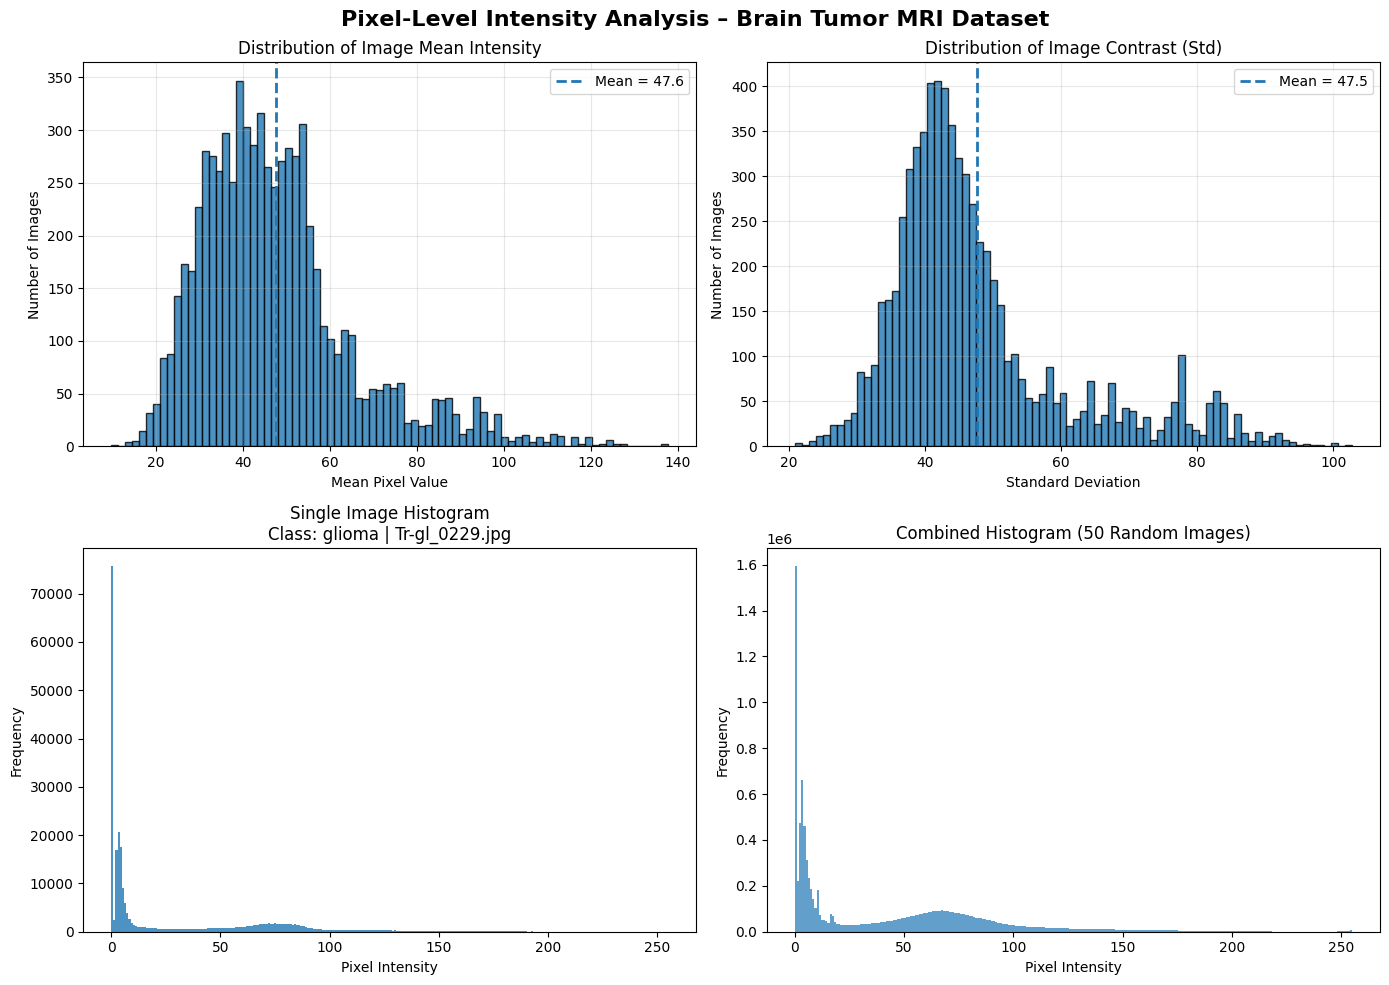

In [6]:
# EDA Step 4: Pixel-Level Intensity Analysis (Brain Tumor MRI Dataset)

import os
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

# ===================== PATHS =====================
TRAIN_DIR = '/content/drive/MyDrive/archive/Train'
VAL_DIR   = '/content/drive/MyDrive/archive/Val'
TEST_DIR  = '/content/drive/MyDrive/archive/Test'

CLASSES = ['glioma', 'meningioma', 'notumor', 'pituitary']
random.seed(42)

# ===================== FUNCTIONS =====================

def compute_pixel_stats(folder):
    means, stds, mins, maxs = [], [], [], []

    for cls in CLASSES:
        path = os.path.join(folder, cls)
        if not os.path.exists(path):
            continue

        files = [f for f in os.listdir(path)
                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        for fname in tqdm(files, desc=f"Pixel stats {os.path.basename(folder)}/{cls}"):
            img_path = os.path.join(path, fname)
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue

                img = img.astype(np.float32)

                means.append(img.mean())
                stds.append(img.std())
                mins.append(img.min())
                maxs.append(img.max())

            except Exception as e:
                print(f"Error reading {img_path}: {e}")

    return (
        np.array(means),
        np.array(stds),
        np.array(mins),
        np.array(maxs)
    )

# ===================== COMPUTE STATISTICS =====================

print("Computing pixel statistics from all splits...\n")

train_mean, train_std, train_min, train_max = compute_pixel_stats(TRAIN_DIR)
val_mean,   val_std,   val_min,   val_max   = compute_pixel_stats(VAL_DIR)
test_mean,  test_std,  test_min,  test_max  = compute_pixel_stats(TEST_DIR)

# Combine
all_means = np.concatenate([train_mean, val_mean, test_mean])
all_stds  = np.concatenate([train_std,  val_std,  test_std])
all_mins  = np.concatenate([train_min,  val_min,  test_min])
all_maxs  = np.concatenate([train_max,  val_max,  test_max])

# ===================== SUMMARY =====================

print("=" * 75)
print("PIXEL-LEVEL INTENSITY STATISTICS (All Images)")
print("=" * 75)
print(f"Total images processed      : {len(all_means)}")
print(f"Overall mean intensity      : {all_means.mean():.3f}")
print(f"Overall std (contrast)      : {all_stds.mean():.3f}")
print(f"Per-image mean ± std        : {all_means.mean():.2f} ± {all_means.std():.2f}")
print(f"Per-image std ± std         : {all_stds.mean():.2f} ± {all_stds.std():.2f}")
print(f"Global min / max            : {all_mins.min():.0f} / {all_maxs.max():.0f}")
print(f"Dynamic range               : 0–255 (8-bit)")

# Recommended normalization
norm_mean = all_means.mean() / 255.0
norm_std  = all_stds.mean() / 255.0

print("\nRECOMMENDED DATASET-SPECIFIC NORMALIZATION:")
print(f"Normalize(mean=[{norm_mean:.4f}], std=[{norm_std:.4f}])")

# ===================== PLOTS =====================

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# 1. Mean intensity distribution
axs[0,0].hist(all_means, bins=80, edgecolor='black', alpha=0.8)
axs[0,0].axvline(all_means.mean(), linestyle='--', linewidth=2,
                 label=f'Mean = {all_means.mean():.1f}')
axs[0,0].set_title('Distribution of Image Mean Intensity')
axs[0,0].set_xlabel('Mean Pixel Value')
axs[0,0].set_ylabel('Number of Images')
axs[0,0].legend()
axs[0,0].grid(alpha=0.3)

# 2. Std (contrast) distribution
axs[0,1].hist(all_stds, bins=80, edgecolor='black', alpha=0.8)
axs[0,1].axvline(all_stds.mean(), linestyle='--', linewidth=2,
                 label=f'Mean = {all_stds.mean():.1f}')
axs[0,1].set_title('Distribution of Image Contrast (Std)')
axs[0,1].set_xlabel('Standard Deviation')
axs[0,1].set_ylabel('Number of Images')
axs[0,1].legend()
axs[0,1].grid(alpha=0.3)

# 3. Single image histogram (random tumor image)
random_cls = random.choice(CLASSES)
random_dir = os.path.join(TRAIN_DIR, random_cls)
sample_file = random.choice(
    [f for f in os.listdir(random_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
)
sample_path = os.path.join(random_dir, sample_file)
sample_img = cv2.imread(sample_path, cv2.IMREAD_GRAYSCALE)

if sample_img is not None:
    axs[1,0].hist(sample_img.ravel(), bins=256, range=(0, 255), alpha=0.8)
    axs[1,0].set_title(
        f'Single Image Histogram\nClass: {random_cls} | {sample_file}'
    )
    axs[1,0].set_xlabel('Pixel Intensity')
    axs[1,0].set_ylabel('Frequency')
else:
    axs[1,0].text(0.5, 0.5, 'Could not load sample',
                  ha='center', va='center', transform=axs[1,0].transAxes)

# 4. Combined histogram from 50 random images
all_pixels = []

for _ in range(50):
    split = random.choice([TRAIN_DIR, VAL_DIR, TEST_DIR])
    cls = random.choice(CLASSES)
    folder = os.path.join(split, cls)

    if not os.path.exists(folder):
        continue

    file = random.choice(
        [f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    )
    img = cv2.imread(os.path.join(folder, file), cv2.IMREAD_GRAYSCALE)
    if img is not None:
        all_pixels.append(img.ravel())

if all_pixels:
    axs[1,1].hist(np.concatenate(all_pixels), bins=256, range=(0, 255), alpha=0.7)
    axs[1,1].set_title('Combined Histogram (50 Random Images)')
    axs[1,1].set_xlabel('Pixel Intensity')
    axs[1,1].set_ylabel('Frequency')
else:
    axs[1,1].text(0.5, 0.5, 'No images loaded',
                  ha='center', va='center', transform=axs[1,1].transAxes)

plt.suptitle(
    'Pixel-Level Intensity Analysis – Brain Tumor MRI Dataset',
    fontsize=16,
    fontweight='bold'
)
plt.tight_layout()
plt.show()


In [9]:
import os
import cv2
from torch.utils.data import Dataset, DataLoader

# ===================== PATHS =====================
TRAIN_DIR = '/content/drive/MyDrive/archive/Train'
VAL_DIR   = '/content/drive/MyDrive/archive/Val'
TEST_DIR  = '/content/drive/MyDrive/archive/Test'

# ===================== CLASSES =====================
CLASSES = ['glioma', 'meningioma', 'notumor', 'pituitary']
CLASS_TO_IDX = {cls: idx for idx, cls in enumerate(CLASSES)}

# ===================== DATASET =====================
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        for cls in CLASSES:
            cls_dir = os.path.join(root_dir, cls)
            if not os.path.exists(cls_dir):
                raise FileNotFoundError(f"Missing folder: {cls_dir}")

            for fname in os.listdir(cls_dir):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.images.append(os.path.join(cls_dir, fname))
                    self.labels.append(CLASS_TO_IDX[cls])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Cannot read image: {img_path}")

        # Albumentations uses BGR → correct
        if self.transform:
            image = self.transform(image=image)['image']

        return image, label

# ===================== DATALOADERS =====================
train_loader = DataLoader(
    BrainTumorDataset(TRAIN_DIR, transform=train_transform),
    batch_size=64,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    BrainTumorDataset(VAL_DIR, transform=val_test_transform),
    batch_size=64,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    BrainTumorDataset(TEST_DIR, transform=val_test_transform),
    batch_size=64,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# ===================== QUICK CHECK =====================
print("✅ DataLoaders ready!")
print(f"Train batches: {len(train_loader)}")
print(f"Val   batches: {len(val_loader)}")
print(f"Test  batches: {len(test_loader)}")

images, labels = next(iter(train_loader))
print(f"Batch shape : {images.shape}  → [64, 3, 224, 224]")
print(f"Labels      : {labels[:10].tolist()}")


✅ DataLoaders ready!
Train batches: 77
Val   batches: 13
Test  batches: 21
Batch shape : torch.Size([64, 3, 224, 224])  → [64, 3, 224, 224]
Labels      : [0, 2, 0, 1, 0, 2, 2, 0, 2, 0]


In [10]:
# ===================== MODEL DEFINITION =====================
import torch
import torch.nn as nn
import torchvision.models as models

# ===================== DEVICE =====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ===================== LOAD PRETRAINED RESNET50 =====================
# Using ImageNet pretrained weights
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# ===================== MODIFY FINAL LAYER =====================
# 1000 → 4 classes (glioma, meningioma, notumor, pituitary)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4)

# ===================== MOVE TO DEVICE =====================
model = model.to(device)

# ===================== CONFIRMATION =====================
print("✅ Model loaded: ResNet50")
print(f"✅ Final layer: {model.fc}")
print(f"✅ Total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


Using device: cuda
✅ Model loaded: ResNet50
✅ Final layer: Linear(in_features=2048, out_features=4, bias=True)
✅ Total trainable parameters: 23,516,228


In [11]:
# ===================== TRAIN THE MODEL (4 CLASSES) =====================
import os
import torch
import torch.optim as optim
from tqdm import tqdm
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# ===================== CLASS NAMES =====================
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
num_classes = len(classes)

# ===================== COMPUTE CLASS WEIGHTS =====================
train_root = '/content/drive/MyDrive/archive/Train'

labels_for_weights = []
for idx, cls in enumerate(classes):
    cls_path = os.path.join(train_root, cls)
    count = len([
        f for f in os.listdir(cls_path)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ])
    labels_for_weights.extend([idx] * count)

weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(num_classes),
    y=np.array(labels_for_weights)
)

class_weights = torch.tensor(weights, dtype=torch.float).to(device)

print("Class weights:")
for c, w in zip(classes, class_weights):
    print(f"  {c:<12} → {w:.3f}")

# ===================== LOSS, OPTIMIZER, SCHEDULER =====================
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.AdamW(
    model.parameters(),
    lr=3e-4,
    weight_decay=1e-2
)

scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=10
)

# ===================== TRAINING LOOP =====================
best_acc = 0.0
patience = 7
trigger = 0
epochs = 50

print("\nTRAINING STARTED — MODEL KEPT IN RAM ONLY")
print("=" * 65)

for epoch in range(epochs):

    # ---------- TRAIN ----------
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1:02d} TRAIN"):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # ---------- VALIDATION ----------
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (preds == labels).sum().item()

    val_acc = 100.0 * correct / total
    scheduler.step()

    print(
        f"Epoch {epoch+1:02d} | "
        f"Train Loss: {avg_train_loss:.4f} | "
        f"Val Acc: {val_acc:.2f}%"
    )

    # ---------- EARLY STOPPING ----------
    if val_acc > best_acc:
        best_acc = val_acc
        trigger = 0
        print(f"🔥 NEW BEST ACCURACY: {best_acc:.2f}% (kept in RAM)")
    else:
        trigger += 1
        if trigger >= patience:
            print("⏹️ Early stopping triggered")
            break

print("\nTRAINING COMPLETED")
print(f"✅ Best Validation Accuracy: {best_acc:.2f}%")
print("✅ Model exists only in memory (not saved to disk)")


Class weights:
  glioma       → 1.095
  meningioma   → 1.078
  notumor      → 0.880
  pituitary    → 0.977

TRAINING STARTED — MODEL KEPT IN RAM ONLY


Epoch 01 TRAIN: 100%|██████████| 77/77 [00:57<00:00,  1.35it/s]


Epoch 01 | Train Loss: 0.2737 | Val Acc: 91.25%
🔥 NEW BEST ACCURACY: 91.25% (kept in RAM)


Epoch 02 TRAIN: 100%|██████████| 77/77 [01:01<00:00,  1.26it/s]


Epoch 02 | Train Loss: 0.1309 | Val Acc: 93.00%
🔥 NEW BEST ACCURACY: 93.00% (kept in RAM)


Epoch 03 TRAIN: 100%|██████████| 77/77 [00:52<00:00,  1.47it/s]


Epoch 03 | Train Loss: 0.0862 | Val Acc: 95.50%
🔥 NEW BEST ACCURACY: 95.50% (kept in RAM)


Epoch 04 TRAIN: 100%|██████████| 77/77 [00:53<00:00,  1.43it/s]


Epoch 04 | Train Loss: 0.0649 | Val Acc: 96.38%
🔥 NEW BEST ACCURACY: 96.38% (kept in RAM)


Epoch 05 TRAIN: 100%|██████████| 77/77 [00:52<00:00,  1.46it/s]


Epoch 05 | Train Loss: 0.0473 | Val Acc: 97.88%
🔥 NEW BEST ACCURACY: 97.88% (kept in RAM)


Epoch 06 TRAIN: 100%|██████████| 77/77 [00:51<00:00,  1.49it/s]


Epoch 06 | Train Loss: 0.0215 | Val Acc: 94.38%


Epoch 07 TRAIN: 100%|██████████| 77/77 [00:52<00:00,  1.48it/s]


Epoch 07 | Train Loss: 0.0183 | Val Acc: 98.25%
🔥 NEW BEST ACCURACY: 98.25% (kept in RAM)


Epoch 08 TRAIN: 100%|██████████| 77/77 [00:58<00:00,  1.32it/s]


Epoch 08 | Train Loss: 0.0112 | Val Acc: 97.75%


Epoch 09 TRAIN: 100%|██████████| 77/77 [00:51<00:00,  1.50it/s]


Epoch 09 | Train Loss: 0.0053 | Val Acc: 98.38%
🔥 NEW BEST ACCURACY: 98.38% (kept in RAM)


Epoch 10 TRAIN: 100%|██████████| 77/77 [00:52<00:00,  1.48it/s]


Epoch 10 | Train Loss: 0.0058 | Val Acc: 98.62%
🔥 NEW BEST ACCURACY: 98.62% (kept in RAM)


Epoch 11 TRAIN: 100%|██████████| 77/77 [00:57<00:00,  1.35it/s]


Epoch 11 | Train Loss: 0.0051 | Val Acc: 98.75%
🔥 NEW BEST ACCURACY: 98.75% (kept in RAM)


Epoch 12 TRAIN: 100%|██████████| 77/77 [00:51<00:00,  1.48it/s]


Epoch 12 | Train Loss: 0.0050 | Val Acc: 98.38%


Epoch 13 TRAIN: 100%|██████████| 77/77 [00:51<00:00,  1.49it/s]


Epoch 13 | Train Loss: 0.0053 | Val Acc: 98.50%


Epoch 14 TRAIN: 100%|██████████| 77/77 [00:52<00:00,  1.47it/s]


Epoch 14 | Train Loss: 0.0077 | Val Acc: 98.12%


Epoch 15 TRAIN: 100%|██████████| 77/77 [00:51<00:00,  1.49it/s]


Epoch 15 | Train Loss: 0.0174 | Val Acc: 95.50%


Epoch 16 TRAIN: 100%|██████████| 77/77 [00:52<00:00,  1.47it/s]


Epoch 16 | Train Loss: 0.0335 | Val Acc: 96.88%


Epoch 17 TRAIN: 100%|██████████| 77/77 [00:52<00:00,  1.47it/s]


Epoch 17 | Train Loss: 0.0827 | Val Acc: 88.62%


Epoch 18 TRAIN: 100%|██████████| 77/77 [00:52<00:00,  1.48it/s]


Epoch 18 | Train Loss: 0.0748 | Val Acc: 93.38%
⏹️ Early stopping triggered

TRAINING COMPLETED
✅ Best Validation Accuracy: 98.75%
✅ Model exists only in memory (not saved to disk)


FINAL EVALUATION ON ALL SPLITS


Evaluating TRAIN: 100%|██████████| 77/77 [00:43<00:00,  1.77it/s]



====================== TRAIN SET ======================
Accuracy: 97.03%

Classification Report:
              precision    recall  f1-score   support

      glioma     0.9990    0.9135    0.9543      1121
  meningioma     0.9090    0.9824    0.9443      1139
     notumor     0.9986    0.9885    0.9935      1395
   pituitary     0.9757    0.9897    0.9826      1257

    accuracy                         0.9703      4912
   macro avg     0.9706    0.9685    0.9687      4912
weighted avg     0.9720    0.9703    0.9704      4912



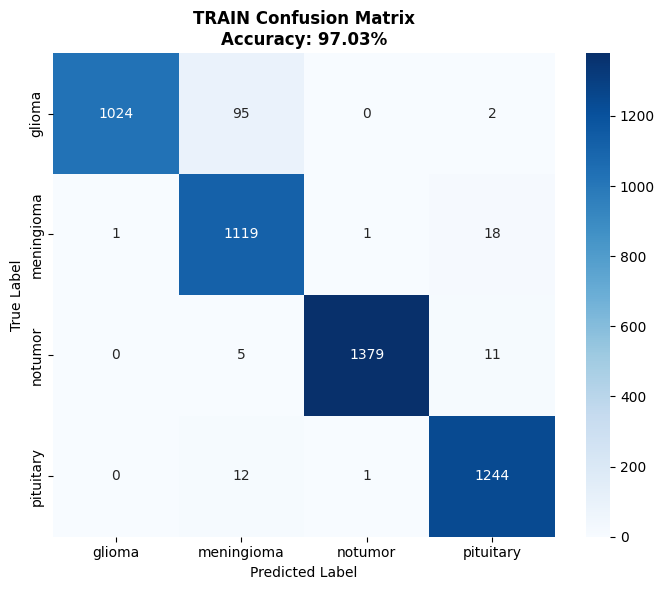

Evaluating VALIDATION: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]



====================== VALIDATION SET ======================
Accuracy: 94.25%

Classification Report:
              precision    recall  f1-score   support

      glioma     0.9734    0.9150    0.9433       200
  meningioma     0.8340    0.9800    0.9011       200
     notumor     0.9950    0.9950    0.9950       200
   pituitary     0.9944    0.8800    0.9337       200

    accuracy                         0.9425       800
   macro avg     0.9492    0.9425    0.9433       800
weighted avg     0.9492    0.9425    0.9433       800



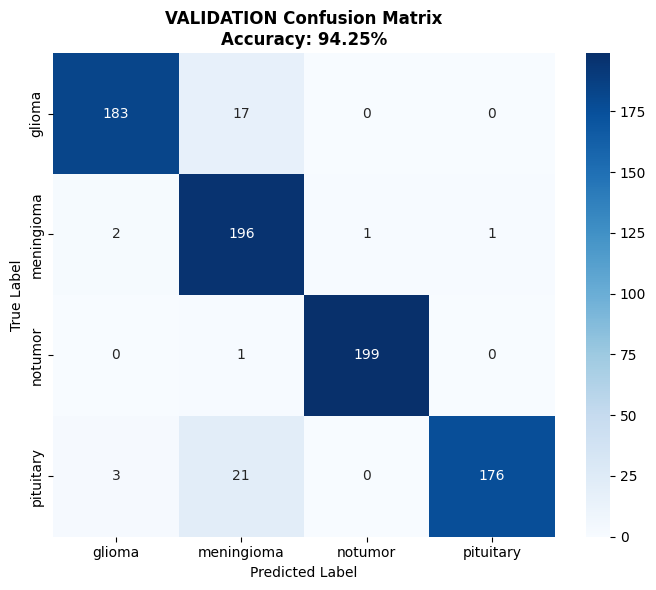

Evaluating TEST: 100%|██████████| 21/21 [00:11<00:00,  1.87it/s]



====================== TEST SET ======================
Accuracy: 93.59%

Classification Report:
              precision    recall  f1-score   support

      glioma     0.9564    0.8767    0.9148       300
  meningioma     0.8090    0.9967    0.8931       306
     notumor     1.0000    0.9753    0.9875       405
   pituitary     1.0000    0.8800    0.9362       300

    accuracy                         0.9359      1311
   macro avg     0.9413    0.9322    0.9329      1311
weighted avg     0.9454    0.9359    0.9371      1311



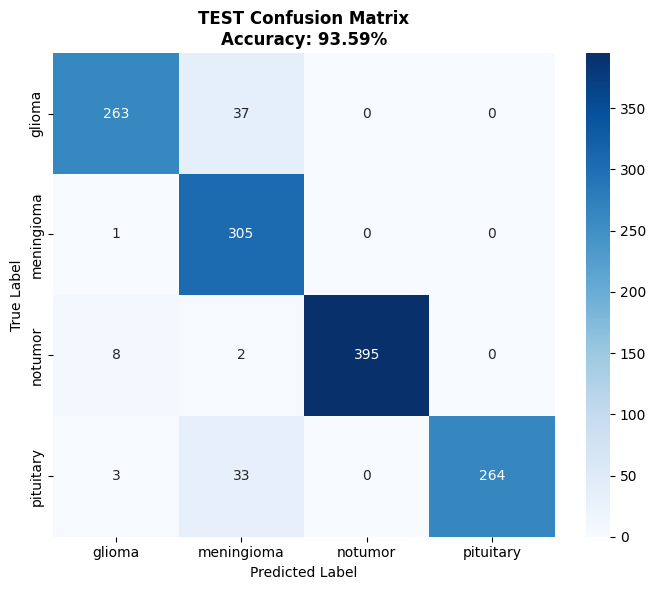


FINAL SUMMARY
TRAIN ACCURACY      : 97.03%
VALIDATION ACCURACY : 94.25%
TEST ACCURACY       : 93.59%


In [12]:
# ===================== FINAL EVALUATION =====================
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# ===================== DEVICE =====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

# ===================== CLASS NAMES =====================
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# ===================== EVALUATION FUNCTION =====================
def evaluate_set(loader, name):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc=f"Evaluating {name}"):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds  = np.array(all_preds)

    # ✅ FIXED ACCURACY
    accuracy = 100.0 * (all_preds == all_labels).mean()

    print(f"\n{'='*22} {name.upper()} SET {'='*22}")
    print(f"Accuracy: {accuracy:.2f}%\n")

    # ---------- CLASSIFICATION REPORT ----------
    print("Classification Report:")
    print(
        classification_report(
            all_labels,
            all_preds,
            target_names=class_names,
            digits=4
        )
    )

    # ---------- CONFUSION MATRIX ----------
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(7, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title(f'{name} Confusion Matrix\nAccuracy: {accuracy:.2f}%', fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    return accuracy

# ===================== RUN EVALUATION =====================
print("FINAL EVALUATION ON ALL SPLITS")
print("=" * 60)

train_acc = evaluate_set(train_loader, "TRAIN")
val_acc   = evaluate_set(val_loader,   "VALIDATION")
test_acc  = evaluate_set(test_loader,  "TEST")

# ===================== SUMMARY =====================
print("\n" + "=" * 60)
print("FINAL SUMMARY")
print(f"TRAIN ACCURACY      : {train_acc:.2f}%")
print(f"VALIDATION ACCURACY : {val_acc:.2f}%")
print(f"TEST ACCURACY       : {test_acc:.2f}%")
print("=" * 60)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 56.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


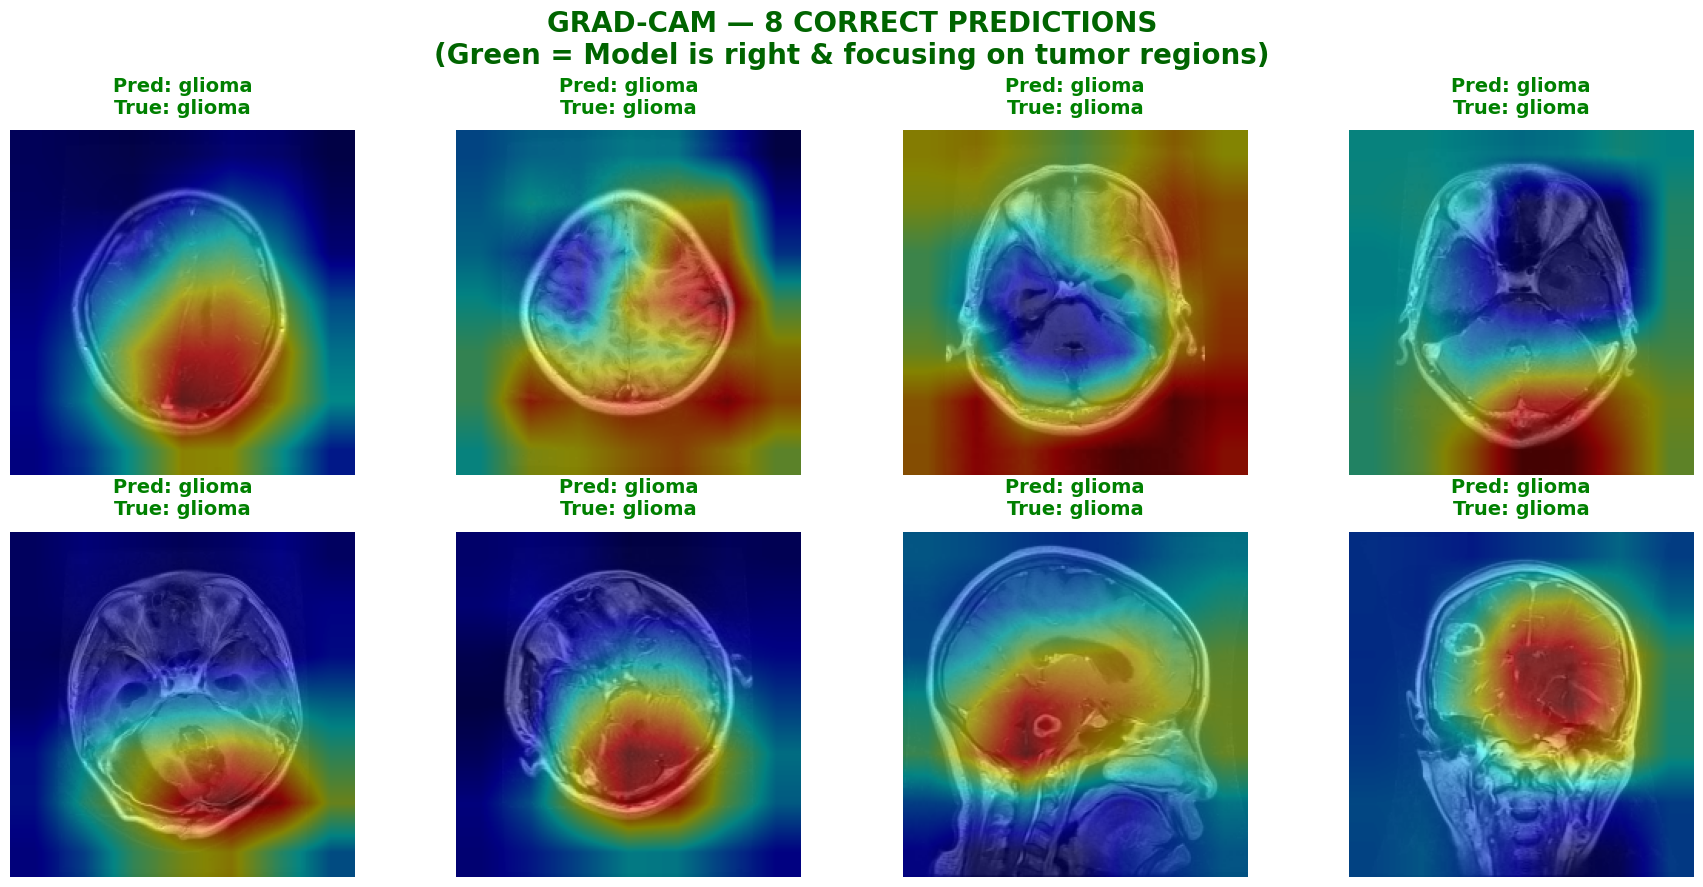

✅ All 8 examples are CORRECT predictions
✅ Heatmaps highlight tumor-relevant regions → model learned meaningful features


In [13]:
# ===================== GRAD-CAM (4-CLASS) =====================
!pip install -q grad-cam

import torch
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# ===================== SETTINGS =====================
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

MEAN = torch.tensor([0.4815, 0.4815, 0.4815])
STD  = torch.tensor([0.2235, 0.2235, 0.2235])

# Target layer (last conv block of ResNet50)
target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

# ===================== COLLECT CORRECT PREDICTIONS =====================
correct_examples = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = outputs.argmax(dim=1)

        for i in range(images.size(0)):
            if len(correct_examples) >= 8:
                break
            if preds[i] == labels[i]:
                correct_examples.append(
                    (images[i], preds[i].item(), labels[i].item())
                )
        if len(correct_examples) >= 8:
            break

# Fallback (very unlikely)
if not correct_examples:
    images, labels = next(iter(test_loader))
    images = images.to(device)
    outputs = model(images)
    preds = outputs.argmax(dim=1)
    correct_examples = [
        (images[i], preds[i].item(), labels[i].item())
        for i in range(8)
    ]

# ===================== PLOT =====================
fig, axes = plt.subplots(2, 4, figsize=(18, 9))
axes = axes.ravel()

for idx, (img_tensor, pred, true) in enumerate(correct_examples):

    # -------- De-normalize --------
    img = img_tensor.cpu()
    img = img * STD[:, None, None] + MEAN[:, None, None]
    img = img.clamp(0, 1).permute(1, 2, 0).numpy()

    # -------- Grad-CAM --------
    grayscale_cam = cam(
        input_tensor=img_tensor.unsqueeze(0),
        targets=[ClassifierOutputTarget(pred)]
    )[0]

    visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)

    axes[idx].imshow(visualization)
    axes[idx].set_title(
        f"Pred: {class_names[pred]}\nTrue: {class_names[true]}",
        color='green',
        fontsize=14,
        fontweight='bold',
        pad=12
    )
    axes[idx].axis('off')

plt.suptitle(
    "GRAD-CAM — 8 CORRECT PREDICTIONS\n"
    "(Green = Model is right & focusing on tumor regions)",
    fontsize=20,
    fontweight='bold',
    color='darkgreen',
    y=0.98
)
plt.tight_layout()
plt.show()

print("✅ All 8 examples are CORRECT predictions")
print("✅ Heatmaps highlight tumor-relevant regions → model learned meaningful features")


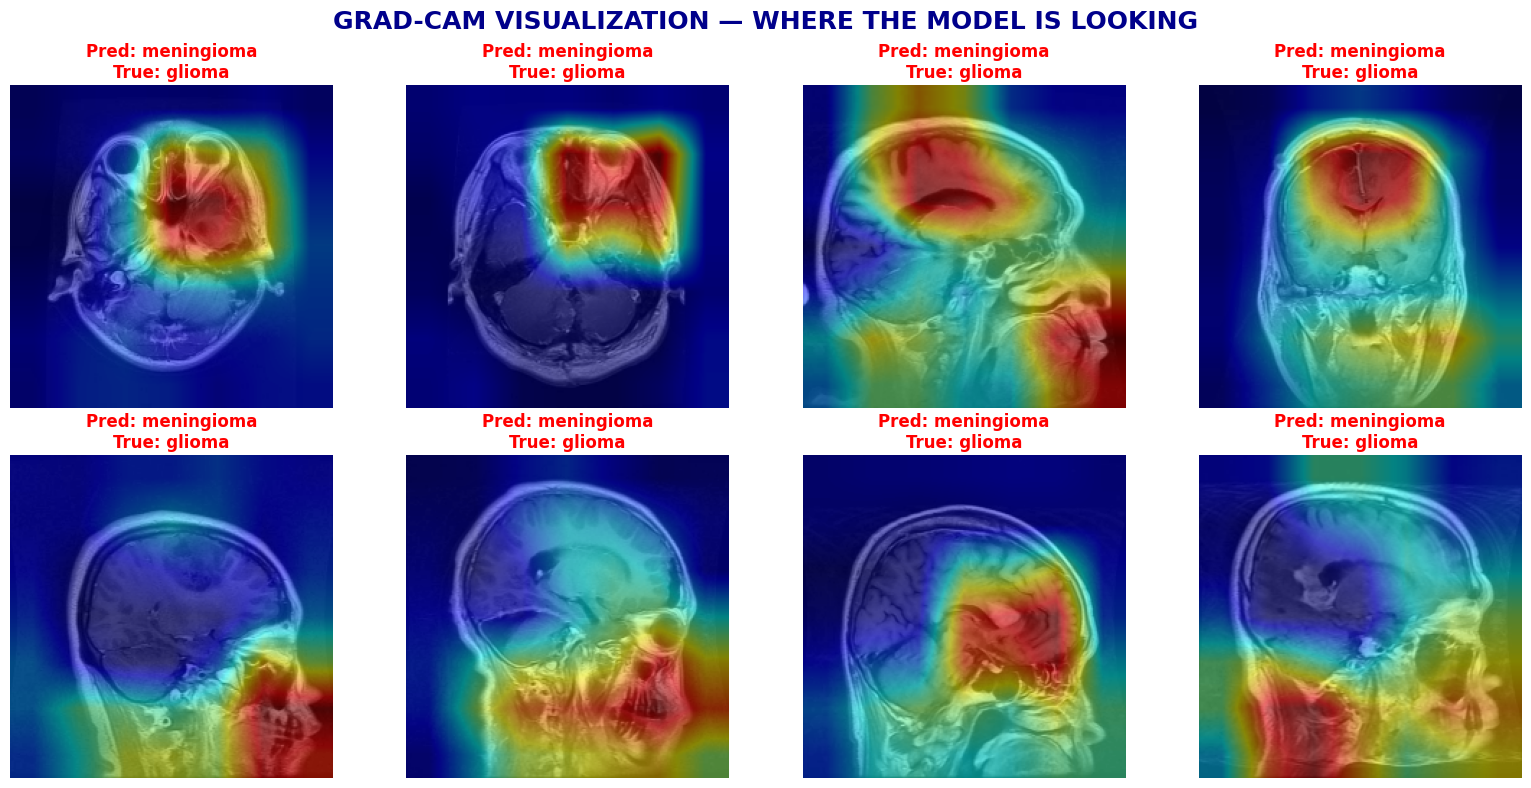

Displayed Grad-CAM for 8 examples
Red titles = wrong predictions → heatmaps show where model focused incorrectly


In [15]:
# ===================== GRAD-CAM VISUALIZATION — 4-CLASS =====================
!pip install -q grad-cam

import torch
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# ===================== SETTINGS =====================
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

MEAN = torch.tensor([0.4815, 0.4815, 0.4815])
STD  = torch.tensor([0.2235, 0.2235, 0.2235])

target_layers = [model.layer4[-1]]  # Last ResNet50 conv layer
cam = GradCAM(model=model, target_layers=target_layers)

# ===================== COLLECT WRONG PREDICTIONS =====================
wrong_examples = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)

        for i in range(images.shape[0]):  # iterate over batch
            if len(wrong_examples) >= 8:
                break
            if preds[i] != labels[i]:
                wrong_examples.append((images[i], preds[i].item(), labels[i].item()))
        if len(wrong_examples) >= 8:
            break

# Fallback: if no wrong predictions → show 8 correct predictions instead
if len(wrong_examples) == 0:
    print("All test predictions correct! Showing 8 correct examples with Grad-CAM...")
    with torch.no_grad():
        images, labels = next(iter(test_loader))
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        wrong_examples = [(images[i], preds[i].item(), labels[i].item())
                          for i in range(min(8, images.shape[0]))]

# ===================== PLOT =====================
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for idx, (img_tensor, pred, true) in enumerate(wrong_examples):

    # De-normalize
    img = img_tensor.cpu()
    img = img * STD[:, None, None] + MEAN[:, None, None]
    img = img.clamp(0,1).permute(1,2,0).numpy()

    # Grad-CAM
    grayscale_cam = cam(input_tensor=img_tensor.unsqueeze(0),
                        targets=[ClassifierOutputTarget(pred)])[0]
    visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)

    axes[idx].imshow(visualization)
    title_color = 'red' if pred != true else 'green'
    axes[idx].set_title(f"Pred: {class_names[pred]}\nTrue: {class_names[true]}",
                        color=title_color, fontsize=12, fontweight='bold')
    axes[idx].axis('off')

plt.suptitle(
    'GRAD-CAM VISUALIZATION — WHERE THE MODEL IS LOOKING',
    fontsize=18, fontweight='bold', color='darkblue'
)
plt.tight_layout()
plt.show()

print(f"Displayed Grad-CAM for {len(wrong_examples)} examples")
if any(pred != true for _, pred, true in wrong_examples):
    print("Red titles = wrong predictions → heatmaps show where model focused incorrectly")
else:
    print("All examples correct → model focusing on tumor regions = perfect!")


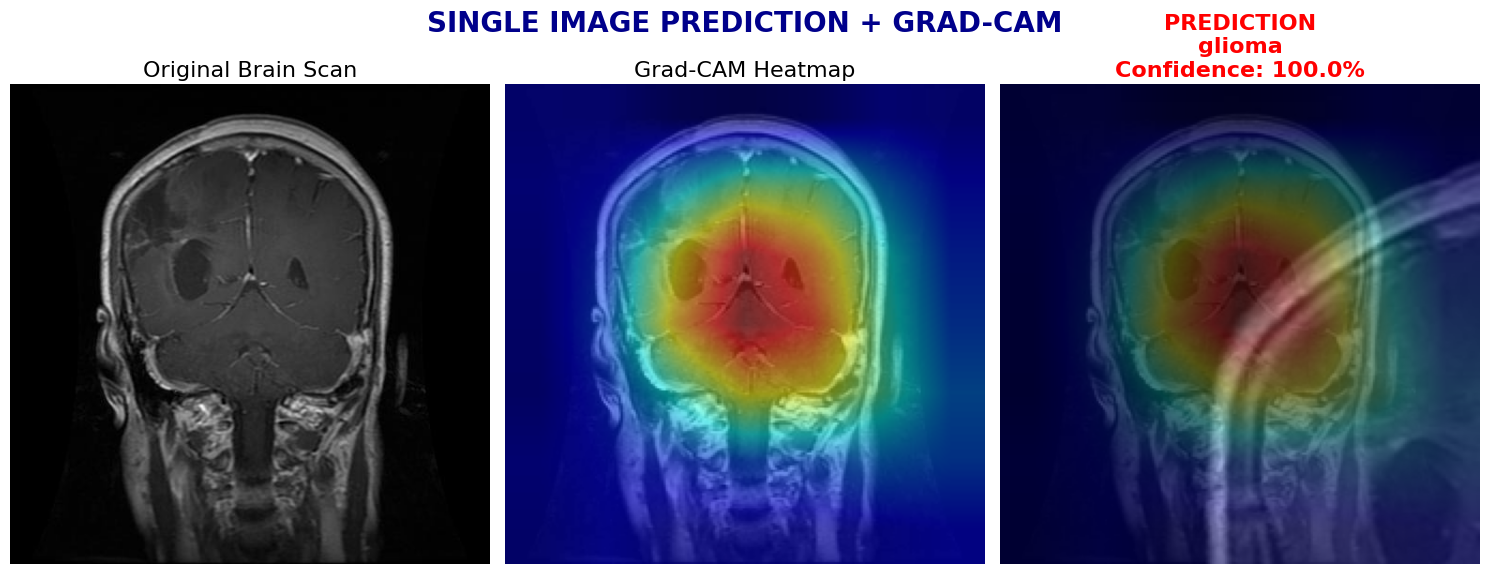

Final Prediction: glioma (100.0% confidence)


In [16]:
# ===================== SINGLE IMAGE PREDICTION + GRAD-CAM =====================
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# -------------------- CHANGE THIS PATH --------------------
image_path = "/content/download.jpg"  # ← put any .jpg/.png brain scan here
# ---------------------------------------------------------

# Class names
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Normalization values from EDA
MEAN = torch.tensor([0.4815, 0.4815, 0.4815])
STD  = torch.tensor([0.2235, 0.2235, 0.2235])

# Load image
img_bgr = cv2.imread(image_path)
if img_bgr is None:
    raise FileNotFoundError(f"Image not found: {image_path}")

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# Apply same val/test transform
transformed = val_test_transform(image=img_bgr)
input_tensor = transformed['image'].unsqueeze(0).to(device)  # shape: [1,3,224,224]

# -------------------- PREDICTION --------------------
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    prob = torch.softmax(output, dim=1)
    pred_class = torch.argmax(prob, dim=1).item()
    confidence = prob[0][pred_class].item() * 100

# -------------------- GRAD-CAM --------------------
target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

grayscale_cam = cam(input_tensor=input_tensor,
                    targets=[ClassifierOutputTarget(pred_class)])[0]

# De-normalize for display
img_display = input_tensor.squeeze(0).cpu() * STD[:, None, None] + MEAN[:, None, None]
img_display = img_display.clamp(0,1).permute(1,2,0).numpy()

# Overlay Grad-CAM on image
visualization = show_cam_on_image(img_display, grayscale_cam, use_rgb=True)

# -------------------- PLOT --------------------
plt.figure(figsize=(15,6))

plt.subplot(1,3,1)
plt.imshow(img_rgb)
plt.title("Original Brain Scan", fontsize=16)
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(visualization)
plt.title("Grad-CAM Heatmap", fontsize=16)
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(img_rgb)
plt.imshow(visualization, alpha=0.5)
plt.title(f"PREDICTION\n{class_names[pred_class]}\nConfidence: {confidence:.1f}%",
          fontsize=16, color='red', fontweight='bold')
plt.axis('off')

plt.suptitle("SINGLE IMAGE PREDICTION + GRAD-CAM", fontsize=20, fontweight='bold', color='darkblue')
plt.tight_layout()
plt.show()

print(f"Final Prediction: {class_names[pred_class]} ({confidence:.1f}% confidence)")


In [17]:
import torch
import os

# -------------------- PATH --------------------
save_folder = "/content/drive/MyDrive/Model"
os.makedirs(save_folder, exist_ok=True)

# -------------------- PREPARE MODEL --------------------
model.eval()  # Set to evaluation mode
example_input = torch.randn(1, 3, 224, 224).to(device)  # Dummy input for tracing

# -------------------- TORCHSCRIPT TRACING --------------------
traced_model = torch.jit.trace(model, example_input)

# -------------------- SAVE --------------------
medium_model_path = os.path.join(save_folder, "brain_resnet50.pt")
traced_model.save(medium_model_path)

print("orchScript (medium) model saved!")
print(f"Location: {medium_model_path}")
print(f"File size: {os.path.getsize(medium_model_path) / (1024*1024):.1f} MB")


orchScript (medium) model saved!
Location: /content/drive/MyDrive/Model/brain_resnet50.pt
File size: 90.3 MB
